<a href="https://colab.research.google.com/github/cwilbar04/nba-predictions/blob/main/notebooks/model_data_creation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from datetime import datetime
import os
import pyarrow
import firebase_admin
from firebase_admin import credentials as cred
from firebase_admin import firestore

In [ ]:
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

In [2]:
my_project_id = "nba-predictions-dev"
raw_game_data_table = 'nba.raw_basketballreference_game'
raw_player_data_table = 'nba.raw_basketballreference_playerbox'

In [3]:
%env GOOGLE_APPLICATION_CREDENTIALS C:\GCP\nba-predictions-dev-d76075f0a064.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\GCP\nba-predictions-dev-d76075f0a064.json


In [4]:
%env GOOGLE_CLOUD_PROJECT nba-predictions-dev

env: GOOGLE_CLOUD_PROJECT=nba-predictions-dev


In [5]:
credentials = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")

In [6]:
client = bigquery.Client(project=my_project_id)

In [7]:
# %%bigquery --project nba-predictions-dev game
#   SELECT * from `nba.raw_basketballreference_game`

In [8]:
# %%bigquery --project nba-predictions-dev player
#   SELECT * from `nba.raw_basketballreference_playerbox`

In [9]:
game = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_game_data_table)).to_dataframe()

In [10]:
player = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_player_data_table)).to_dataframe()

In [11]:
game_original = game.copy()
player_original = player.copy()

In [12]:
game[game['game_date']==game['game_date'].max()]

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
6101,2021-03-04,8:00p,Denver Nuggets,DEN,113,Indiana Pacers,IND,103,/boxscores/202103040IND.html,0,...,.533,12.8,23.9,.078,107.5,2021-03-05 12:00:11+00:00,None,None,None,None
7372,2021-03-04,7:30p,Detroit Pistons,DET,104,New York Knicks,NYK,114,/boxscores/202103040NYK.html,"1,981",...,.596,12.5,34.3,.181,125.8,2021-03-05 12:00:10+00:00,None,None,None,None
8356,2021-03-04,10:00p,Golden State Warriors,GSW,98,Phoenix Suns,PHO,120,/boxscores/202103040PHO.html,"3,233",...,.573,13.6,27.9,.104,117.2,2021-03-05 12:00:13+00:00,None,None,None,None
11382,2021-03-04,7:00p,Los Angeles Clippers,LAC,117,Washington Wizards,WAS,119,/boxscores/202103040WAS.html,0,...,.506,7.8,23.9,.341,119.3,2021-03-05 12:00:09+00:00,None,None,None,None
13775,2021-03-04,8:30p,Miami Heat,MIA,103,New Orleans Pelicans,NOP,93,/boxscores/202103040NOP.html,"2,700",...,.464,12.4,30.0,.193,106.2,2021-03-05 12:00:12+00:00,None,None,None,None
14602,2021-03-04,8:00p,Milwaukee Bucks,MIL,112,Memphis Grizzlies,MEM,111,/boxscores/202103040MEM.html,"1,961",...,.436,9.7,30.4,.228,106.5,2021-03-05 12:00:11+00:00,None,None,None,None
18653,2021-03-04,9:00p,Oklahoma City Thunder,OKC,107,San Antonio Spurs,SAS,102,/boxscores/202103040SAS.html,"1,000",...,.529,17.4,14.3,.141,100.1,2021-03-05 12:00:12+00:00,None,None,None,None
23110,2021-03-04,10:00p,Sacramento Kings,SAC,119,Portland Trail Blazers,POR,123,/boxscores/202103040POR.html,0,...,.563,7.5,21.4,.273,128.8,2021-03-05 12:00:13+00:00,None,None,None,None
24718,2021-03-04,7:00p,Toronto Raptors,TOR,125,Boston Celtics,BOS,132,/boxscores/202103040BOS.html,0,...,.696,14.9,31.0,.392,134.1,2021-03-05 12:00:09+00:00,None,None,None,None


In [13]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
0,2015-02-11,7:30p,Atlanta Hawks,ATL,88,Boston Celtics,BOS,89,/boxscores/201502110BOS.html,"16,083",...,.376,8.9,29.1,.204,96.1,2021-02-27 21:44:28+00:00,None,None,None,None
1,2015-01-14,8:00p,Atlanta Hawks,ATL,105,Boston Celtics,BOS,91,/boxscores/201501140BOS.html,"16,067",...,.476,15.2,31.0,.145,102.8,2021-02-27 21:42:37+00:00,None,None,None,None
2,2019-03-16,12:30p,Atlanta Hawks,ATL,120,Boston Celtics,BOS,129,/boxscores/201903160BOS.html,"18,624",...,.543,11.4,26.2,.301,121.0,2021-02-24 19:56:37+00:00,None,None,None,None
3,1999-12-22,None,Atlanta Hawks,ATL,81,Boston Celtics,BOS,98,/boxscores/199912220BOS.html,"15,973",...,.536,12.0,15.4,.108,108.0,2021-02-27 13:31:36+00:00,None,None,None,None
4,2000-04-10,None,Atlanta Hawks,ATL,94,Boston Celtics,BOS,99,/boxscores/200004100BOS.html,"15,006",...,.525,12.0,21.6,.203,110.4,2021-02-27 13:41:00+00:00,None,None,None,None


In [14]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,IND20210303CLE700p,2021-03-03,h,CLE,game,Lamar Stevens,/players/s/stevela01.html,stevela01,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|stevela01|game,False,2021-03-04 12:00:10+00:00
1,IND20210303CLE700p,2021-03-03,h,CLE,game,Larry Nance,/players/n/nancela02.html,nancela02,Did Not Dress,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|nancela02|game,False,2021-03-04 12:00:10+00:00
2,IND20210303CLE700p,2021-03-03,a,IND,game,Kelan Martin,/players/m/martike03.html,martike03,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|martike03|game,False,2021-03-04 12:00:10+00:00
3,IND20210303CLE700p,2021-03-03,a,IND,game,Goga Bitadze,/players/b/bitadgo01.html,bitadgo01,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|bitadgo01|game,False,2021-03-04 12:00:10+00:00
4,IND20210303CLE700p,2021-03-03,a,IND,game,JaKarr Sampson,/players/s/sampsja02.html,sampsja02,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|sampsja02|game,False,2021-03-04 12:00:10+00:00


In [15]:
game.describe()

<ipython-input-15-84ddafb79ca7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  game.describe()


,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
count,27463,26199,27463,27463,27463,27463,27463,27463,27463,27463,...,27463,27463,27463,27463,27463,27463,1689,371,1560,242
unique,4386,31,36,37,104,36,37,100,27463,8630,...,435,247,410,525,737,16342,23,22,23,20
top,2014-04-16,8:00p,San Antonio Spurs,SAS,98,San Antonio Spurs,SAS,99,/boxscores/200301180LAC.html,"18,997",...,.500,12.4,25.0,.250,107.5,2021-02-24 21:14:30+00:00,8,10,9,7
freq,15,5219,989,989,896,996,996,904,1,874,...,962,351,790,345,117,4,186,40,176,35
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-02-24 17:00:22+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-03-05 12:00:13+00:00,NaN,NaN,NaN,NaN


In [16]:
player.describe()

<ipython-input-16-3fd90b7a743d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  player.describe()


,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
count,676213,676213,676213,676213,676213,676213,676213,676213,110383,565830,...,565830,565830,565830,565830,565830,565830,565753,676213,676213,676213
unique,27463,4386,2,37,1,2129,2143,2143,4,3308,...,26,11,13,14,8,66,103,676213,2,16410
top,MIL20030419NJN1230p,2016-11-25,h,SAS,game,Vince Carter,/players/c/cartevi01.html,cartevi01,Did Not Play,12:00,...,0,0,0,0,1,0,0,PHI20131201DET330p|thompho01|game,False,2021-02-24 21:14:37+00:00
freq,33,388,338266,24515,676213,1714,1714,1714,89934,1549,...,173786,301197,391887,193495,129691,67725,26248,1,401583,104
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 17:00:22+00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-05 12:00:14+00:00


In [64]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565753 entries, 0 to 565752
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   game_key         565753 non-null  object             
 1   game_date        565753 non-null  object             
 2   h_or_a           565753 non-null  object             
 3   team_abbrev      565753 non-null  object             
 4   stat_period      565753 non-null  object             
 5   player           565753 non-null  object             
 6   player_link      565753 non-null  object             
 7   player_key       565753 non-null  object             
 8   reason           0 non-null       object             
 9   mp               565753 non-null  object             
 10  fg               565753 non-null  object             
 11  fga              565753 non-null  object             
 12  fg_pct           536256 non-null  object             
 13 

In [17]:
game['home_spread'] = game['home_pts'].astype(int) - game['visitor_pts'].astype(int)

<AxesSubplot:>

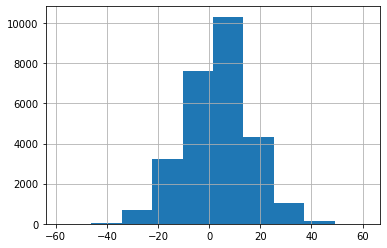

In [18]:
game['home_spread'].hist()

In [19]:
game['season'] = ''
for i in range(len(game)):
  if ((game['game_date'][i].year != 2020 and game['game_date'][i].month < 7) or (game['game_date'][i].year == 2020 and game['game_date'][i].month < 11)):
    game.loc[i,'season'] = game['game_date'][i].year
  else:
    game.loc[i,'season'] = game['game_date'][i].year + 1


In [20]:
game[game['season']=='']

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season


In [21]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season
0,2015-02-11,7:30p,Atlanta Hawks,ATL,88,Boston Celtics,BOS,89,/boxscores/201502110BOS.html,"16,083",...,29.1,.204,96.1,2021-02-27 21:44:28+00:00,None,None,None,None,1,2015
1,2015-01-14,8:00p,Atlanta Hawks,ATL,105,Boston Celtics,BOS,91,/boxscores/201501140BOS.html,"16,067",...,31.0,.145,102.8,2021-02-27 21:42:37+00:00,None,None,None,None,-14,2015
2,2019-03-16,12:30p,Atlanta Hawks,ATL,120,Boston Celtics,BOS,129,/boxscores/201903160BOS.html,"18,624",...,26.2,.301,121.0,2021-02-24 19:56:37+00:00,None,None,None,None,9,2019
3,1999-12-22,None,Atlanta Hawks,ATL,81,Boston Celtics,BOS,98,/boxscores/199912220BOS.html,"15,973",...,15.4,.108,108.0,2021-02-27 13:31:36+00:00,None,None,None,None,17,2000
4,2000-04-10,None,Atlanta Hawks,ATL,94,Boston Celtics,BOS,99,/boxscores/200004100BOS.html,"15,006",...,21.6,.203,110.4,2021-02-27 13:41:00+00:00,None,None,None,None,5,2000


In [22]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27463 entries, 0 to 27462
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   game_date          27463 non-null  object             
 1   game_start_time    26199 non-null  object             
 2   visitor_team_name  27463 non-null  object             
 3   away_abbr          27463 non-null  object             
 4   visitor_pts        27463 non-null  object             
 5   home_team_name     27463 non-null  object             
 6   home_abbr          27463 non-null  object             
 7   home_pts           27463 non-null  object             
 8   box_score_url      27463 non-null  object             
 9   attendance         27463 non-null  object             
 10  overtimes          27463 non-null  object             
 11  game_key           27463 non-null  object             
 12  a_g1_score         27463 non-null  object     

In [30]:
games_by_team_home = pd.DataFrame()
games_by_team_home['season'] = game['season']
games_by_team_home['game_key'] = game['game_key'] + 'h'
games_by_team_home['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_home['team'] = game['home_team_name']
games_by_team_home['opponent'] = game['visitor_team_name']
games_by_team_home['is_home_team'] = 1
games_by_team_home['spread'] = game['home_spread']
games_by_team_home['pace'] = game['h_ff_pace']
games_by_team_home['efg_pct'] = game['h_ff_efg_pct']
games_by_team_home['tov_pct'] = game['h_ff_tov_pct']
games_by_team_home['orb_pct'] = game['h_ff_tov_pct']
games_by_team_home['ft_rate'] = game['h_ff_ft_rate']
games_by_team_home['off_rtg'] = game['h_ff_off_rtg']
games_by_team_home['opponent_efg_pct'] = game['a_ff_efg_pct']
games_by_team_home['opponent_tov_pct'] = game['a_ff_tov_pct']
games_by_team_home['opponent_orb_pct'] = game['a_ff_orb_pct']
games_by_team_home['opponent_ft_rate'] = game['a_ff_ft_rate']
games_by_team_home['opponent_off_rtg'] = game['a_ff_off_rtg']


games_by_team_home['is_win'] = ''
for i in range(len(game)):
  games_by_team_home.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) > 0 else 0

In [31]:
games_by_team_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27463 entries, 0 to 27462
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            27463 non-null  object        
 1   game_key          27463 non-null  object        
 2   game_date         27463 non-null  datetime64[ns]
 3   team              27463 non-null  object        
 4   opponent          27463 non-null  object        
 5   is_home_team      27463 non-null  int64         
 6   spread            27463 non-null  int32         
 7   pace              27463 non-null  object        
 8   efg_pct           27463 non-null  object        
 9   tov_pct           27463 non-null  object        
 10  orb_pct           27463 non-null  object        
 11  ft_rate           27463 non-null  object        
 12  off_rtg           27463 non-null  object        
 13  opponent_efg_pct  27463 non-null  object        
 14  opponent_tov_pct  2746

In [32]:
games_by_team_visitor = pd.DataFrame()
games_by_team_visitor ['season'] = game['season']
games_by_team_visitor ['game_key'] = game['game_key'] + 'a'
games_by_team_visitor ['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_visitor ['team'] = game['visitor_team_name']
games_by_team_visitor ['opponent'] = game['home_team_name']
games_by_team_visitor ['is_home_team'] = 0
games_by_team_visitor ['spread'] = game['home_spread']*-1
games_by_team_visitor ['pace'] = game['a_ff_pace']
games_by_team_visitor['efg_pct'] = game['a_ff_efg_pct']
games_by_team_visitor['tov_pct'] = game['a_ff_tov_pct']
games_by_team_visitor['orb_pct'] = game['a_ff_tov_pct']
games_by_team_visitor['ft_rate'] = game['a_ff_ft_rate']
games_by_team_visitor['off_rtg'] = game['a_ff_off_rtg']
games_by_team_visitor['opponent_efg_pct'] = game['h_ff_efg_pct']
games_by_team_visitor['opponent_tov_pct'] = game['h_ff_tov_pct']
games_by_team_visitor['opponent_orb_pct'] = game['h_ff_orb_pct']
games_by_team_visitor['opponent_ft_rate'] = game['h_ff_ft_rate']
games_by_team_visitor['opponent_off_rtg'] = game['h_ff_off_rtg']

games_by_team_visitor['is_win'] = ''
for i in range(len(game)):
  games_by_team_visitor.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) < 0 else 0

In [33]:
games_by_team_visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27463 entries, 0 to 27462
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            27463 non-null  object        
 1   game_key          27463 non-null  object        
 2   game_date         27463 non-null  datetime64[ns]
 3   team              27463 non-null  object        
 4   opponent          27463 non-null  object        
 5   is_home_team      27463 non-null  int64         
 6   spread            27463 non-null  int32         
 7   pace              27463 non-null  object        
 8   efg_pct           27463 non-null  object        
 9   tov_pct           27463 non-null  object        
 10  orb_pct           27463 non-null  object        
 11  ft_rate           27463 non-null  object        
 12  off_rtg           27463 non-null  object        
 13  opponent_efg_pct  27463 non-null  object        
 14  opponent_tov_pct  2746

In [34]:
games_by_team = pd.concat([games_by_team_home,games_by_team_visitor])

In [35]:
games_by_team['is_win'].unique()

array([1, 0], dtype=object)

In [36]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54926 entries, 0 to 27462
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            54926 non-null  object        
 1   game_key          54926 non-null  object        
 2   game_date         54926 non-null  datetime64[ns]
 3   team              54926 non-null  object        
 4   opponent          54926 non-null  object        
 5   is_home_team      54926 non-null  int64         
 6   spread            54926 non-null  int32         
 7   pace              54926 non-null  object        
 8   efg_pct           54926 non-null  object        
 9   tov_pct           54926 non-null  object        
 10  orb_pct           54926 non-null  object        
 11  ft_rate           54926 non-null  object        
 12  off_rtg           54926 non-null  object        
 13  opponent_efg_pct  54926 non-null  object        
 14  opponent_tov_pct  5492

In [37]:
games_by_team[games_by_team['is_win']=='']

,season,game_key,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win


In [38]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,IND20210303CLE700p,2021-03-03,h,CLE,game,Lamar Stevens,/players/s/stevela01.html,stevela01,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|stevela01|game,False,2021-03-04 12:00:10+00:00
1,IND20210303CLE700p,2021-03-03,h,CLE,game,Larry Nance,/players/n/nancela02.html,nancela02,Did Not Dress,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|nancela02|game,False,2021-03-04 12:00:10+00:00
2,IND20210303CLE700p,2021-03-03,a,IND,game,Kelan Martin,/players/m/martike03.html,martike03,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|martike03|game,False,2021-03-04 12:00:10+00:00
3,IND20210303CLE700p,2021-03-03,a,IND,game,Goga Bitadze,/players/b/bitadgo01.html,bitadgo01,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|bitadgo01|game,False,2021-03-04 12:00:10+00:00
4,IND20210303CLE700p,2021-03-03,a,IND,game,JaKarr Sampson,/players/s/sampsja02.html,sampsja02,Did Not Play,None,...,None,None,None,None,None,None,None,IND20210303CLE700p|sampsja02|game,False,2021-03-04 12:00:10+00:00


In [39]:
player['game_key'] = player['game_key'] + player['h_or_a']

In [40]:
player = player.dropna(subset=['mp', 'plus_minus']).reset_index(drop=True)

In [41]:
player['plus_minus'] = player['plus_minus'].astype(int)

In [42]:
def convert_to_seconds(x):
  sp = int(x.split(':')[0]) * 60 + int(x.split(':')[1])
  return sp

In [43]:
player['seconds_played'] = player['mp'].apply(convert_to_seconds)

In [44]:
player['seconds_played'] = player['seconds_played'].astype(int)

In [45]:
game_player_stats = pd.DataFrame()
game_player_stats['game_key'] = player['game_key'].unique()

In [46]:
game_player_stats.head()

,game_key
0,IND20210303CLE700ph
1,IND20210303CLE700pa
2,UTA20210303PHI700ph
3,UTA20210303PHI700pa
4,DET20210303TOR700ph


In [47]:
a = player.groupby(['game_key'])['seconds_played'].sum()

In [48]:
b = player[player['starter_flag']==True].groupby(['game_key'])['seconds_played'].sum()

In [49]:
seconds = pd.merge(a, b, left_index=True, right_index=True, how='inner')

In [50]:
seconds['starter_minutes_played_proportion'] = seconds['seconds_played_y']/seconds['seconds_played_x']

In [51]:
seconds.head()

,seconds_played_x,seconds_played_y,starter_minutes_played_proportion
game_key,,,
ATL19991102WASa,14400,10818,0.751250
ATL19991102WASh,14400,8373,0.581458
ATL19991108DENa,14400,10913,0.757847
ATL19991108DENh,14400,9834,0.682917
ATL19991110VANa,15901,12202,0.767373


In [52]:
game_player_stats.set_index('game_key',inplace=True)

In [53]:
game_player_stats = pd.merge(game_player_stats,seconds['starter_minutes_played_proportion'],left_index=True,right_index=True,how='inner')

In [54]:
game_player_stats.head()

,starter_minutes_played_proportion
game_key,
IND20210303CLE700ph,0.646458
IND20210303CLE700pa,0.676250
UTA20210303PHI700ph,0.666792
UTA20210303PHI700pa,0.724969
DET20210303TOR700ph,0.537917


In [55]:
bench_pl_min = player[player['starter_flag']==False].groupby(['game_key'])['plus_minus'].sum()

In [56]:
game_player_stats = pd.merge(game_player_stats,bench_pl_min, left_index=True, right_index=True, how='inner')

In [57]:
game_player_stats = game_player_stats.rename(columns={'plus_minus':'bench_plus_minus'})

In [58]:
game_player_stats.head()

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
IND20210303CLE700ph,0.646458,-66
IND20210303CLE700pa,0.676250,36
UTA20210303PHI700ph,0.666792,17
UTA20210303PHI700pa,0.724969,20
DET20210303TOR700ph,0.537917,-81


In [59]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54926 entries, 0 to 27462
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            54926 non-null  object        
 1   game_key          54926 non-null  object        
 2   game_date         54926 non-null  datetime64[ns]
 3   team              54926 non-null  object        
 4   opponent          54926 non-null  object        
 5   is_home_team      54926 non-null  int64         
 6   spread            54926 non-null  int32         
 7   pace              54926 non-null  object        
 8   efg_pct           54926 non-null  object        
 9   tov_pct           54926 non-null  object        
 10  orb_pct           54926 non-null  object        
 11  ft_rate           54926 non-null  object        
 12  off_rtg           54926 non-null  object        
 13  opponent_efg_pct  54926 non-null  object        
 14  opponent_tov_pct  5492

In [60]:
games_by_team.set_index('game_key', inplace=True)

In [61]:
games_by_team = pd.merge(games_by_team,game_player_stats, left_index=True, right_index=True,how='inner')

In [62]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,
ATL20150211BOS730ph,2015,2015-02-11,Boston Celtics,Atlanta Hawks,1,1,92.6,.376,8.9,8.9,.204,96.1,.468,12.0,11.1,.192,95.0,1,0.571696,33
ATL20150114BOS800ph,2015,2015-01-14,Boston Celtics,Atlanta Hawks,1,-14,88.5,.476,15.2,15.2,.145,102.8,.562,12.4,18.2,.315,118.7,0,0.533472,-13
ATL20190316BOS1230ph,2019,2019-03-16,Boston Celtics,Atlanta Hawks,1,9,106.6,.543,11.4,11.4,.301,121.0,.505,13.3,35.2,.190,112.6,1,0.681944,-1
ATL19991222BOSh,2000,1999-12-22,Boston Celtics,Atlanta Hawks,1,17,90.7,.536,12.0,12.0,.108,108.0,.411,12.6,25.5,.203,89.3,1,0.652965,-9
ATL20000410BOSh,2000,2000-04-10,Boston Celtics,Atlanta Hawks,1,5,89.7,.525,12.0,12.0,.203,110.4,.515,19.7,28.1,.353,104.8,1,0.573750,6


In [63]:
game_player_stats

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
IND20210303CLE700ph,0.646458,-66
IND20210303CLE700pa,0.676250,36
UTA20210303PHI700ph,0.666792,17
UTA20210303PHI700pa,0.724969,20
DET20210303TOR700ph,0.537917,-81
...,...,...
MIN20010102WAS700ph,0.756458,-4
ATL20200306WAS700ph,0.644653,-17
SAC20070317ORL700pa,0.741667,31


In [65]:
game_player_stats_opponent = game_player_stats.copy()

In [66]:
game_player_stats_opponent.reset_index(drop=False, inplace=True)

In [67]:
def switch_key(key):
  new_key = key[:-1] + ('h' if key[-1] == 'a' else 'a')
  return new_key

In [68]:
game_player_stats_opponent['game_key'] = game_player_stats_opponent['game_key'].apply(switch_key)

In [69]:
game_player_stats_opponent = game_player_stats_opponent.rename(columns={'starter_minutes_played_proportion':'opponnent_starter_minutes_played_proportion','bench_plus_minus':'opponent_bench_plus_minus'})

In [70]:
game_player_stats_opponent.set_index('game_key', inplace=True)

In [71]:
games_by_team = pd.merge(games_by_team,game_player_stats_opponent,left_index=True,right_index=True,how='inner')

In [72]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,...,opponent_efg_pct,opponent_tov_pct,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20150211BOS730ph,2015,2015-02-11,Boston Celtics,Atlanta Hawks,1,1,92.6,.376,8.9,8.9,...,.468,12.0,11.1,.192,95.0,1,0.571696,33,0.719097,-5
ATL20150114BOS800ph,2015,2015-01-14,Boston Celtics,Atlanta Hawks,1,-14,88.5,.476,15.2,15.2,...,.562,12.4,18.2,.315,118.7,0,0.533472,-13,0.630947,-31
ATL20190316BOS1230ph,2019,2019-03-16,Boston Celtics,Atlanta Hawks,1,9,106.6,.543,11.4,11.4,...,.505,13.3,35.2,.190,112.6,1,0.681944,-1,0.639236,13
ATL19991222BOSh,2000,1999-12-22,Boston Celtics,Atlanta Hawks,1,17,90.7,.536,12.0,12.0,...,.411,12.6,25.5,.203,89.3,1,0.652965,-9,0.654677,23
ATL20000410BOSh,2000,2000-04-10,Boston Celtics,Atlanta Hawks,1,5,89.7,.525,12.0,12.0,...,.515,19.7,28.1,.353,104.8,1,0.573750,6,0.715208,-13


In [73]:
games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)]

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,...,opponent_efg_pct,opponent_tov_pct,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
BOS20181123ATL730ph,2019,2018-11-23,Atlanta Hawks,Boston Celtics,1,-18,106.6,.469,17.6,17.6,...,.533,13.8,16.7,.187,106.9,0,0.423750,23,0.464722,46
BOS20190119ATL730ph,2019,2019-01-19,Atlanta Hawks,Boston Celtics,1,-8,101.1,.500,16.9,16.9,...,.511,13.2,23.4,.261,111.7,0,0.637153,6,0.601042,49
BRK20190309ATL700ph,2019,2019-03-09,Atlanta Hawks,Brooklyn Nets,1,-2,105.7,.410,7.7,7.7,...,.471,11.3,27.8,.384,107.9,0,0.586303,-47,0.594069,35
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,.393,18.9,18.9,...,.506,18.2,17.8,.157,95.3,0,0.566250,25,0.540833,49
CHI20190301ATL730ph,2019,2019-03-01,Atlanta Hawks,Chicago Bulls,1,-7,100.6,.585,13.0,13.0,...,.559,10.2,18.0,.294,117.9,0,0.515147,-14,0.692451,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATL20190402SAS830pa,2019,2019-04-02,Atlanta Hawks,San Antonio Spurs,0,-6,100.9,.521,9.7,9.7,...,.613,15.1,11.1,.238,116.0,0,0.575972,6,0.664514,-39
ATL20190108TOR730pa,2019,2019-01-08,Atlanta Hawks,Toronto Raptors,0,-3,103.8,.517,21.7,21.7,...,.525,16.4,14.0,.250,100.2,0,0.675069,-27,0.704653,-15
ATL20190201UTA900pa,2019,2019-02-01,Atlanta Hawks,Utah Jazz,0,-16,105.4,.469,9.2,9.2,...,.598,13.0,25.6,.276,121.4,0,0.605208,-28,0.646806,-15


In [74]:
def generate_streak_info(data,column):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate streak data

    column:
      Stirng with specific column name to generate streak info

    Returns
    -------

    data_with_streak_counter:
        The original dataframe with a new column
        `streak_counter_[column]` containing integers with 
        counts for each streak.
    """
    
    data['start_of_streak'] = data[column].ne(data[column].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data[f'streak_counter_{column}'] = data.groupby('streak_id').cumcount() + 1
    data_with_streak_counter = data.drop(columns = ['start_of_streak','streak_id'] )
    return data_with_streak_counter

In [75]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])
testing2 = games_by_team.loc[(games_by_team['team']=='Washington Wizards') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [76]:
testing = generate_streak_info(testing,'is_win')
testing2 = generate_streak_info(testing2,'is_win')

In [77]:
# Make negative streak if losing streak, positive if winning streak
testing['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing['streak_counter_is_win'],testing['is_win'])]
testing['incoming_is_win_streak'] = testing['streak_counter_is_win'].shift(fill_value=0)
testing2['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing2['streak_counter_is_win'],testing2['is_win'])]
testing2['incoming_is_win_streak'] = testing2['streak_counter_is_win'].shift(fill_value=0)


In [78]:
test = pd.concat([testing, testing2])

In [79]:
test.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,...,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,19.7,...,20.8,.242,111.0,0,0.587986,-45,0.523958,49,-1,0
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,16.1,...,19.4,.370,123.6,0,0.519444,-26,0.495208,-49,-2,-1
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,10.1,...,30.0,.091,104.7,1,0.585069,57,0.642569,-79,1,-2
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,.489,12.5,12.5,...,17.0,.176,96.2,1,0.611806,2,0.677431,39,2,1
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,.393,18.9,18.9,...,17.8,.157,95.3,0,0.566250,25,0.540833,49,-1,2


In [80]:
test.loc[(test['team']=='Washington Wizards') & (test['season']==2019)]

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,...,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak
game_key,,,,,,,,,,,,,,,,,,,,,
MIA20181018WAS800ph,2019,2018-10-18,Washington Wizards,Miami Heat,1,-1,101.9,.512,12.5,12.5,...,40.0,.258,110.8,0,0.554514,-8,0.652639,13,-1,0
TOR20181020WAS700ph,2019,2018-10-20,Washington Wizards,Toronto Raptors,1,-4,102.0,.489,9.6,9.6,...,33.3,.330,114.7,0,0.596111,-44,0.570972,-7,-2,-1
WAS20181022POR1000pa,2019,2018-10-22,Washington Wizards,Portland Trail Blazers,0,1,107.4,.486,7.6,7.6,...,28.8,.250,104.6,1,0.592327,0,0.598113,-2,1,-2
WAS20181024GSW1030pa,2019,2018-10-24,Washington Wizards,Golden State Warriors,0,-22,106.7,.516,10.2,10.2,...,27.0,.250,134.9,0,0.433194,-49,0.551528,32,-1,1
WAS20181026SAC1000pa,2019,2018-10-26,Washington Wizards,Sacramento Kings,0,-4,108.9,.547,17.9,17.9,...,27.5,.147,106.5,0,0.636111,11,0.635000,-48,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAS20190331DEN800pa,2019,2019-03-31,Washington Wizards,Denver Nuggets,0,5,99.6,.435,9.0,9.0,...,21.1,.140,90.4,1,0.738333,12,0.609514,-31,1,-1
CHI20190403WAS700ph,2019,2019-04-03,Washington Wizards,Chicago Bulls,1,-1,107.8,.490,10.0,10.0,...,23.1,.156,106.7,0,0.609514,0,0.538403,11,-1,1
SAS20190405WAS700ph,2019,2019-04-05,Washington Wizards,San Antonio Spurs,1,-17,94.3,.528,8.4,8.4,...,32.4,.187,136.8,0,0.655694,-48,0.585556,16,-2,-1


In [81]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [82]:
testing['pace'].unique()

array(['113.5', '106.0', '108.1', '101.7', '105.5', '105.7', '112.9',
       '100.5', '108.0', '101.5', '102.9', '103.9', '96.8', '106.2',
       '107.4', '107.1', '99.7', '106.6', '101.6', '106.7', '104.0',
       '107.5', '110.6', '101.3', '106.5', '101.2', '102.8', '100.6',
       '101.8', '102.3', '99.8', '96.9', '99.6', '112.3', '97.3', '103.8',
       '104.8', '98.1', '110.2', '104.9', '101.1', '99.3', '97.8', '98.0',
       '105.2', '105.4', '100.4', '98.2', '95.7', '111.4', '97.0', '96.2',
       '100.8', '102.6', '97.6', '104.4', '104.6', '103.0', '98.7',
       '105.9', '100.9', '110.9', '107.7'], dtype=object)

In [83]:
testing['pace'] = testing['pace'].astype(float)

In [85]:
# Set W to number of days desired for moving average
W = 10
weights = np.arange(1,W+1)

In [86]:
testing['pace'].rolling(10).apply(lambda pace: np.dot(pace, weights)/weights.sum(), raw=True)

game_key
ATL20181017NYK730pa           NaN
ATL20181019MEM800pa           NaN
ATL20181021CLE600pa           NaN
DAL20181024ATL700ph           NaN
CHI20181027ATL730ph           NaN
                          ...    
ATL20190402SAS830pa    104.201818
PHI20190403ATL730ph    103.758182
ATL20190405ORL700pa    105.016364
ATL20190407MIL700pa    105.614545
IND20190410ATL800ph    106.127273
Name: pace, Length: 82, dtype: float64

In [87]:
def create_linear_weighted_moving_average(data,column,W):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate weighted moving average.

    column:
      Stirng with specific column name to generate weighted moving average info.
      Column must be ready to be converted to float data type.

    Returns
    -------

    data_with_moving_average:
        The original dataframe with a new column
        `wma_[W]_[column]` containing float values with weighted moving average
        values for the provided value with a weight of W.
    """  
    data_with_moving_average = data.copy()
    data_with_moving_average[column] = data_with_moving_average[column].astype(float)
    weights = np.arange(1,W+1) 
    data_with_moving_average[f'wma_{W}_{column}'] = data_with_moving_average[column].rolling(W).apply(lambda col: np.dot(col, weights)/weights.sum(), raw=True)
    return data_with_moving_average

In [88]:
testing4 = create_linear_weighted_moving_average(testing,'efg_pct',10)

In [89]:
testing4 = create_linear_weighted_moving_average(testing4,'bench_plus_minus',10)

In [90]:
testing4.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,orb_pct,...,opponent_orb_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,wma_10_efg_pct,wma_10_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,0.511,19.7,19.7,...,20.8,.242,111.0,0,0.587986,-45.0,0.523958,49,NaN,NaN
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,0.578,16.1,16.1,...,19.4,.370,123.6,0,0.519444,-26.0,0.495208,-49,NaN,NaN
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,0.602,10.1,10.1,...,30.0,.091,104.7,1,0.585069,57.0,0.642569,-79,NaN,NaN
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,0.489,12.5,12.5,...,17.0,.176,96.2,1,0.611806,2.0,0.677431,39,NaN,NaN
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,0.393,18.9,18.9,...,17.8,.157,95.3,0,0.566250,25.0,0.540833,49,NaN,NaN


In [ ]:
games_by_team_with_streak = pd.DataFrame()
wma_columns = ['pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus']
W = 10
for team in games_by_team['team'].unique():
  team_games = games_by_team.loc[games_by_team['team']==team].sort_values(by='game_date')
  team_games = generate_streak_info(team_games,'is_win')
  team_games['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(team_games['streak_counter_is_win'],team_games['is_win'])]
  team_games['incoming_is_win_streak'] = team_games['streak_counter_is_win'].shift()
  for col in wma_columns:
    team_games = create_linear_weighted_moving_average(team_games,col,W)
    team_games[f'incoming_wma_{W}_{col}'] = team_games[f'wma_{W}_{col}'].shift()
  games_by_team_with_streak = pd.concat([games_by_team_with_streak, team_games])

In [ ]:
games_by_team = games_by_team_with_streak.copy()

In [ ]:
games_by_team.head(12)

In [ ]:
games_by_team.columns

In [ ]:
model_game_data = games_by_team.copy()

In [ ]:
model_game_data.head()

In [ ]:
model_game_data = games_by_team.dropna(subset=['incoming_wma_10_pace'])

In [ ]:
model_game_data.info()

In [ ]:
model_game_data['is_win'].unique()

In [ ]:
model_game_data['season'].unique()

In [ ]:
model_game_data = model_game_data.astype({'season': int, 'is_win': int})

In [ ]:
model_game_data.reset_index(drop=False,inplace=True)

In [ ]:
model_game_data.head()

In [ ]:
model_game_data.columns

In [ ]:
most_recent_game = model_game_data.sort_values('game_date').drop_duplicates(['team'],keep='last')

In [ ]:
most_recent_game = most_recent_game[['season', 'game_date', 'team','streak_counter_is_win',
       'wma_10_pace', 'wma_10_efg_pct', 'wma_10_tov_pct', 'wma_10_ft_rate',
       'wma_10_off_rtg', 'wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'wma_10_starter_minutes_played_proportion', 'wma_10_bench_plus_minus',
       'wma_10_opponnent_starter_minutes_played_proportion',
       'wma_10_opponent_bench_plus_minus']]

In [ ]:
most_recent_game.reset_index(drop=True, inplace=True)

In [ ]:
most_recent_game.set_index('team', inplace=True)

In [ ]:
docs = most_recent_game.to_dict(orient='index')

In [ ]:
most_recent_game.index.unique()

In [ ]:
docs['Cleveland Cavaliers']

In [ ]:
#!pip install google-cloud-secret-manager

In [ ]:
credentials

In [ ]:
default_app = firebase_admin.initialize_app()

In [ ]:
db = firestore.client()

In [ ]:
for team in most_recent_game.index.unique():
    doc_ref = db.collection('team_model_data').document(team)
    doc_ref.set(docs[team])
    print(docs[team])

In [ ]:

docs = db.collection('team_model_data').stream()
teams = []
for doc in docs:
    teams.append(doc.id)
    #print(f'{doc.id} => {doc.to_dict()}')

In [ ]:
teams

In [ ]:
doc_ref = db.collection('team_model_data').document('Atlanta Hawks')

doc = doc_ref.get().to_dict()

In [ ]:
doc

In [ ]:

if doc.exists:
    print(f'Document data: {doc.to_dict()}')
else:
    print(u'No such document!')

In [ ]:
client = bigquery.Client(project=my_project_id)

In [ ]:
model_table_name = 'nba.model_game'

In [ ]:

#Publish model data
job_config = bigquery.LoadJobConfig()
job_config.autodetect='True'
job_config.create_disposition = 'CREATE_IF_NEEDED'
#Truncate for now 
job_config.write_disposition = 'WRITE_TRUNCATE'
job_config.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="game_date")
## Set schema for specific columns where more information is needed (e.g. not NULLABLE or specific date/time)
job_config.schema = [
    bigquery.SchemaField('game_key','STRING', 'REQUIRED'),
    bigquery.SchemaField('team','STRING', 'REQUIRED'),
    bigquery.SchemaField('opponent','STRING', 'REQUIRED'),
    bigquery.SchemaField('game_date','DATE'),
]
job_model = client.load_table_from_dataframe(model_game_data, model_table_name, job_config=job_config)


In [ ]:
model_result = job_model.result()
model_message = (
    f'Job ID: {model_result.job_id} '
    f'was started {model_result.started} '
    f'and ended {model_result.ended} '
    f'loading {model_result.output_rows} row(s) '
    f'to {model_result.destination}')


In [ ]:
print(model_message)